# Formulas for PoI Spoofing Attacks Analysis

In [1]:
# import libraries
import pandas as pd
import requests
import json
import numpy as np
import seaborn as sns
import sympy
from sympy import *

# initialize symbols for sympy
X, c_O, c_I, r_i, l, Δ, R_i, σ, ψ, τ_d, D  = symbols('X c_O c_I r_i l Δ, R_i, σ, ψ, τ_d, D')

## Equation 23

Original:

<img src="images/eq_23.png" width="800" />

Print formula to LaTeX:

In [2]:
2 * ((sqrt(X)-sqrt(c_O+c_I))/sqrt(r_i*l)) * sqrt(X) * (sqrt(r_i*l+Δ)-sqrt(r_i*l)) - ((sqrt(X)-sqrt(c_O+c_I))**2)/(r_i*l) * Δ - c_O

2*sqrt(X)*(sqrt(X) - sqrt(c_I + c_O))*(-sqrt(l*r_i) + sqrt(l*r_i + Δ))/sqrt(l*r_i) - c_O - Δ*(sqrt(X) - sqrt(c_I + c_O))**2/(l*r_i)

## Equation 25

Original:

<img src="images/eq_25.png" width="500" />

In [3]:
Piecewise((σ*ψ, σ*ψ < τ_d/(1-τ_d)), ((σ*ψ)/(1+D) + (τ_d*D)/((1-τ_d)*(1+D)), σ*ψ >= τ_d/(1-τ_d)))

Piecewise((σ*ψ, σ*ψ < τ_d/(1 - τ_d)), (D*τ_d/((1 - τ_d)*(D + 1)) + σ*ψ/(D + 1), True))

# Define Functions

Helper functions to solve equations 23 and 25, as well as pull subgraph data for current token supply and total curation signal in the network, used to convert `X` (indexing reward) to curation signal with the last function

In [4]:
def fun25():
    # calculate delta
    return Piecewise((σ*ψ, σ*ψ < τ_d/(1-τ_d)), ((σ*ψ)/(1+D) + (τ_d*D)/((1-τ_d)*(1+D)), σ*ψ >= τ_d/(1-τ_d)))
# define equation 23
def fun23(X):
    # calculate new delta
    delta = fun25()
    # get results of equation 23
    return 2 * ((sqrt(X)-sqrt(c_O+c_I))/sqrt(r_i*l)) * sqrt(X) * (sqrt(r_i*l+delta)-sqrt(r_i*l)) - ((sqrt(X)-sqrt(c_O+c_I))**2)/(r_i*l) * delta - c_O

def query_supply():
    """
    Query subgraph data to get current GRT supply.
    Used to convert indexing_reward to curation signal.
    """
    query = '''{
    graphNetworks{
        totalSupply
    }
    }'''
    # set endpoint url
    url = 'https://api.thegraph.com/subgraphs/name/graphprotocol/graph-network-mainnet'
    # make the request
    r = requests.post(url, json={'query': query})
    # load result into json
    json_data = json.loads(r.text)
    # convert json into a dataframe
    df = pd.DataFrame(json_data['data']['graphNetworks'])
    # return supply (adjusted by 10^18)
    return float(df['totalSupply'].astype('float').div(10**18))

def query_total_signal():
    """
    Query subgraph data to get current total tokens signalled.
    Used to convert indexing_reward to curation signal.
    """
    query = '''{
    graphNetworks{
        totalTokensSignalled
    }
    }'''
    # set endpoint url
    url = 'https://api.thegraph.com/subgraphs/name/graphprotocol/graph-network-mainnet'
    # make the request
    r = requests.post(url, json={'query': query})
    # load result into json
    json_data = json.loads(r.text)
    # convert json into a dataframe
    df = pd.DataFrame(json_data['data']['graphNetworks'])
    # return supply (adjusted by 10^18)
    return float(df['totalTokensSignalled'].astype('float').div(10**18))

def convert_indexing_reward_to_signal(indexing_reward, GRT_inflation, GRT_USD, allocation_length=28/365, total_supply=query_supply(), totalTokensSignalled=query_total_signal()):
    """
    Convert indexing_reward - which is derived from solution of fun23_solve_indexing_reward() - to curation signal.
    If GRT inflation is 3%, set GRT_inflation to 0.03 (not 3).
    Keep default parameters for total_supply and totalTokensSignalled when running.
    Example usage: convert_indexing_reward_to_signal(1000, 0.027, 0.45)
    """
    # calculate GRT issuance per epoch using current supply and inflation
    GRTIssuancePerEpoch = total_supply * (GRT_inflation)/365
    # use USD price of GRT to calculate the USD issuance per epoch distributed as indexing rewards
    USDIssuancePerEpoch = GRT_USD*GRTIssuancePerEpoch
    # find relationship between USD issuance and 
    USD_issuance_by_token_signalled = USDIssuancePerEpoch/totalTokensSignalled
    # convert indexing_reward to curation signal
    return indexing_reward/(USD_issuance_by_token_signalled*(allocation_length*365))

# Heatmap

## Set Default Parameters

In [5]:
# l - allocation duration, measured as a fraction of a year
l = 28/365 # 0.074 assumes allocation duration of just over 27 days

# r_i - annual opportunity cost of indexer
r_i = 0.2 # assuming it's on the level of corporate junk bonds - 20%

# σ - probability of an attacker being detected
σ = 0.2

# ψ - slashing percentage - 2.5%
ψ = 0.025

# τ_d - delegation tax - 0.5%
τ_d = 0.005

# D - max delegation ratio
D = 16

# infrastructure costs
c_I = 60 
c_O = 20

## Generate Heatmap

In [ ]:
# set default value for GRT inflation
GRT_inflation = 0.027
# pull values for supply and total signal
total_supply = query_supply()
total_tokens_signalled = query_total_signal()
# initialize arrays for heatmap
results_data = pd.DataFrame([])
# iterate over values
for r_i in [0.01,0.03,0.05,0.1,0.15,0.2,0.25,0.3]:
    #print(i)
    for GRT_USD in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]:
        # calculate new result for equation 23
        result_eq23 = solve(fun23(X), X)
        # get min of equation 24 results
        result_eq23_min = min(result_eq23)
        indexing_reward_to_signal = convert_indexing_reward_to_signal(result_eq23_min, GRT_inflation, GRT_USD, l, total_supply, total_tokens_signalled)
        # store minimum result of either equation in dataframe
        results_data = results_data.append(pd.DataFrame({'r_i': r_i, 'GRT_USD': GRT_USD, 'x_min': int(result_eq23_min), 'curation_min': indexing_reward_to_signal}, index=[0]), ignore_index=True)


<AxesSubplot:xlabel='GRT_USD', ylabel='r_i'>

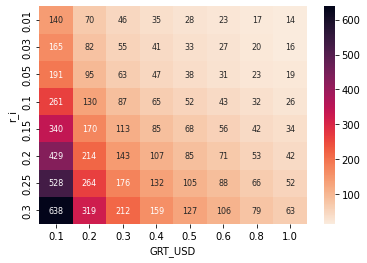

In [7]:
# convert to int
results_data['curation_min'] = results_data['curation_min'].astype('int')
#pivot data
results_data_pivot = results_data.pivot("r_i", "GRT_USD", "curation_min")
# show data
sns.heatmap(results_data_pivot, annot=True,fmt='g', cmap="rocket_r", annot_kws={"size": 8})

# Sensitivity Analysis Tools/Functions

This section has code that is meant to facilitate doing sensitivity analysis and larger parameter sweeps

## Define functions

In [8]:
def fun25(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio):
    """
    Calculate delta - equation 25. Piecewise function.
    """
    return Piecewise((probability_caught*slashing_percentage, probability_caught*slashing_percentage < delegation_tax/(1-delegation_tax)), ((probability_caught*slashing_percentage)/(1+max_delegation_ratio) + (delegation_tax*max_delegation_ratio)/((1-delegation_tax)*(1+max_delegation_ratio)), probability_caught*slashing_percentage >= delegation_tax/(1-delegation_tax)))

def fun23_solve_indexing_reward(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio, honest_indexer_only_cost, honest_and_attacker_cost, interest_rate_opp_cost, other_opportunity_cost, allocation_length, indexing_reward=symbols('indexing_reward')):
    """
    Solve function 23 for indexing_reward. Uses fun25() to calculate delta which is a needed input.
    Do not provide input for indexing_reward and use default of indexing_reward=symbols('indexing_reward').
    Example: fun23_solve_indexing_reward(0.5, 0.025, 0.05, 16, 200, 200, 0.05, 0.05, 28/365)
    """
    # calculate new delta
    delta = fun25(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio)
    # get results of equation 23
    return min(solve(2 * ((sqrt(indexing_reward)-sqrt(honest_indexer_only_cost+honest_and_attacker_cost))/sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length)) * sqrt(indexing_reward) * (sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length+delta)-sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length)) - ((sqrt(indexing_reward)-sqrt(honest_indexer_only_cost+honest_and_attacker_cost))**2)/((interest_rate_opp_cost+other_opportunity_cost)*allocation_length) * delta - honest_indexer_only_cost, indexing_reward)) # solve for indexing_reward

def fun23_solve_honest_indexer_only_cost(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio, indexing_reward, honest_and_attacker_cost, interest_rate_opp_cost, other_opportunity_cost, allocation_length, honest_indexer_only_cost=symbols('honest_indexer_only_cost')):
    """
    Solve function 23 for indexing_reward. Uses fun25() to calculate delta which is a needed input.
    Do not provide input for honest_indexer_only_cost and use default of honest_indexer_only_cost=symbols('honest_indexer_only_cost').
    Example: fun23_solve_honest_indexer_only_cost(0.5, 0.025, 0.05, 16, 5000, 200, 0.05, 0.05, 28/365)
    """
    # calculate new delta
    delta = fun25(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio)
    # get results of equation 23
    return min(solve(2 * ((sqrt(indexing_reward)-sqrt(honest_indexer_only_cost+honest_and_attacker_cost))/sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length)) * sqrt(indexing_reward) * (sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length+delta)-sqrt((interest_rate_opp_cost+other_opportunity_cost)*allocation_length)) - ((sqrt(indexing_reward)-sqrt(honest_indexer_only_cost+honest_and_attacker_cost))**2)/((interest_rate_opp_cost+other_opportunity_cost)*allocation_length) * delta - honest_indexer_only_cost, honest_indexer_only_cost)) # solve for honest_indexer_only_cost

# Utility for sensitivity analysis
def sensitivity_analysis(probability_caught_from=0.2, probability_caught_to=0.9, probability_caught_step=1, slashing_percentage_from=0.025, slashing_percentage_to=0.026, slashing_percentage_step=1, delegation_tax_from=0.05, delegation_tax_to=0.1, delegation_tax_step=1, max_delegation_ratio_from=10, max_delegation_ratio_to=16, max_delegation_ratio_step=10, indexing_reward_from=5000, indexing_reward_to=50000, indexing_reward_step=100000, honest_and_attacker_cost_from=10, honest_and_attacker_cost_to=200, honest_and_attacker_cost_step=1000, interest_rate_opp_cost_from=0.03, interest_rate_opp_cost_to=0.2, interest_rate_opp_cost_step=1, other_opportunity_cost_from=0.03, other_opportunity_cost_to=0.2, other_opportunity_cost_step=1, allocation_length_from=20/365, allocation_length_to=30/365, allocation_length_step=100, honest_indexer_only_cost_from=1, honest_indexer_only_cost_to=200, honest_indexer_only_cost_step=1000, GRT_inflation_from=0.025, GRT_inflation_to=0.03, GRT_inflation_step=1, GRT_USD_from=0.3, GRT_USD_to=1, GRT_USD_step=10):
    """
    Iterate over parameter ranges for fun23_solve_indexing_reward() and make dataframe.
    Example usage with defaults (which will only run 1 iteration with defaults): sensitivity_analysis()
    For full run, adjust whatever parameters as needed.
    For example, sensitivity_analysis(probability_caught_step=0.1) would result in 7 runs with defaults of probability of being caught between 20% and 90%.
    """
    # initialize dataframe
    df = pd.DataFrame(columns=['probability_caught', 'slashing_percentage', 'delegation_tax', 'max_delegation_ratio', 'indexing_reward', 'indexing_reward_to_signal', 'honest_and_attacker_cost', 'interest_rate_opp_cost', 'other_opportunity_cost', 'allocation_length', 'GRT_inflation', 'GRT_USD', 'honest_indexer_only_cost', 'indexing_reward_solved', 'solved_indexing_reward_to_signal', 'honest_indexer_only_cost_solved'])
    # only query for supply once when doing conversion from X to signal
    total_supply = query_supply()
    totalTokensSignalled = query_total_signal()
    # track round
    round = 0
    # iterate over parameter ranges
    for probability_caught in np.arange(probability_caught_from, probability_caught_to, probability_caught_step):
        for slashing_percentage in np.arange(slashing_percentage_from, slashing_percentage_to, slashing_percentage_step):
            for delegation_tax in np.arange(delegation_tax_from, delegation_tax_to, delegation_tax_step):
                for max_delegation_ratio in np.arange(max_delegation_ratio_from, max_delegation_ratio_to, max_delegation_ratio_step):
                    for indexing_reward in np.arange(indexing_reward_from, indexing_reward_to, indexing_reward_step):
                        for honest_and_attacker_cost in np.arange(honest_and_attacker_cost_from, honest_and_attacker_cost_to, honest_and_attacker_cost_step):
                            for interest_rate_opp_cost in np.arange(interest_rate_opp_cost_from, interest_rate_opp_cost_to, interest_rate_opp_cost_step):
                                for other_opportunity_cost in np.arange(other_opportunity_cost_from, other_opportunity_cost_to, other_opportunity_cost_step):
                                    for allocation_length in np.arange(allocation_length_from, allocation_length_to, allocation_length_step):
                                        for honest_indexer_only_cost in np.arange(honest_indexer_only_cost_from, honest_indexer_only_cost_to, honest_indexer_only_cost_step):
                                            for GRT_inflation in np.arange(GRT_inflation_from, GRT_inflation_to, GRT_inflation_step):
                                                for GRT_USD in np.arange(GRT_USD_from, GRT_USD_to, GRT_USD_step):
                                                    # solve for indexing_reward
                                                    indexing_reward_solved = fun23_solve_indexing_reward(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio,honest_indexer_only_cost, honest_and_attacker_cost, interest_rate_opp_cost, other_opportunity_cost, allocation_length)
                                                    # solve for honest_indexer_only_cost
                                                    honest_indexer_only_cost_solved = fun23_solve_honest_indexer_only_cost(probability_caught, slashing_percentage, delegation_tax, max_delegation_ratio, indexing_reward, honest_and_attacker_cost, interest_rate_opp_cost, other_opportunity_cost, allocation_length)
                                                    # convert indexing reward to signal
                                                    indexing_reward_to_signal = convert_indexing_reward_to_signal(indexing_reward, GRT_inflation, GRT_USD, allocation_length, total_supply, totalTokensSignalled)
                                                    # convert solved indexing reward to signal
                                                    solved_indexing_reward_to_signal = convert_indexing_reward_to_signal(indexing_reward_solved, GRT_inflation, GRT_USD, allocation_length, total_supply, totalTokensSignalled)
                                                    # append to dataframe
                                                    df = df.append({'probability_caught': probability_caught, 'slashing_percentage': slashing_percentage, 'delegation_tax': delegation_tax, 'max_delegation_ratio': max_delegation_ratio, 'honest_and_attacker_cost': honest_and_attacker_cost, 'interest_rate_opp_cost': interest_rate_opp_cost, 'other_opportunity_cost': other_opportunity_cost, 'allocation_length': allocation_length, 'GRT_inflation': GRT_inflation, 'GRT_USD': GRT_USD, 'indexing_reward': indexing_reward, 'indexing_reward_to_signal': indexing_reward_to_signal, 'honest_indexer_only_cost': honest_indexer_only_cost, 'indexing_reward_solved': indexing_reward_solved, 'solved_indexing_reward_to_signal': solved_indexing_reward_to_signal, 'honest_indexer_only_cost_solved': honest_indexer_only_cost_solved}, ignore_index=True)
                                                    # print round
                                                    round += 1
                                                    print('Round: ' + str(round))
    # return dataframe with results
    return df

## Run Parameter Sweep (example)

Can now use `sensitivity_analysis()` to create a dataset sweeping over a larger choice of options for further analysis. Internally we ran multiple simulations and created a dataset we could further analyze to look at different scenarios. Below is an illustrative example of one of the simulations we ran.

In [ ]:
data = sensitivity_analysis(probability_caught_from=0.5, probability_caught_to=1, probability_caught_step=0.1, indexing_reward_from=500, indexing_reward_to=5000, indexing_reward_step=1000, max_delegation_ratio_from=16, max_delegation_ratio_to=17, honest_and_attacker_cost_step=50, honest_indexer_only_cost_step=50, GRT_inflation_step=0.005, GRT_USD_from=0.1, GRT_USD_to=0.7, GRT_USD_step=0.3, allocation_length_from=28/365, allocation_length_to=29/365, allocation_length_step=100,interest_rate_opp_cost_from=0.03, interest_rate_opp_cost_to=0.2, interest_rate_opp_cost_step=0.05, other_opportunity_cost_from=0.03, other_opportunity_cost_to=0.2, other_opportunity_cost_step=0.05)

In [ ]:
# show data
data